In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [4]:
# region_id = 5883 # freiburtg
region_id = 69333 # prague

In [5]:

etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/tessellations_chars_{region_id}.parquet')
tess = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/tessellations_chars_{region_id}.parquet')
buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/buildings_chars_{region_id}.parquet')
streets = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/streets_chars_{region_id}.parquet')
nodes = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/nodes_chars_{region_id}.parquet')
primary = pd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/primary_chars_{region_id}.parquet')

In [6]:
# streets.explore()

In [7]:
def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [8]:
etcs = morphotopes_to_etcs(region_id, model_params='_75_0_None_None_False')

In [9]:
primary['morph'] = etcs['morph']

In [10]:
%%time
morph_chars = primary.groupby('morph').mean()

CPU times: user 62.5 ms, sys: 1.09 ms, total: 63.6 ms
Wall time: 63.1 ms


In [11]:
morphotopes = morph_chars[morph_chars.index.str.split('_').str[-1] != '-1']

In [12]:
from sklearn.preprocessing import StandardScaler
component_data = morphotopes

vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [13]:
to_drop = ['stcSAl','stbOri','stcOri','stbCeA', 
           'ldkAre', 'ldkPer', 'lskCCo', 'lskERI',
           'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe']


component_data = component_data.drop(columns=to_drop)

In [14]:
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

In [15]:
# tr_data = embedding
tr_data = component_data

In [16]:
final_linkage = 'ward'
final_metric = 'euclidean'

In [17]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    metric=final_metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(tr_data)
linkage_matrix = get_linkage_matrix(model)

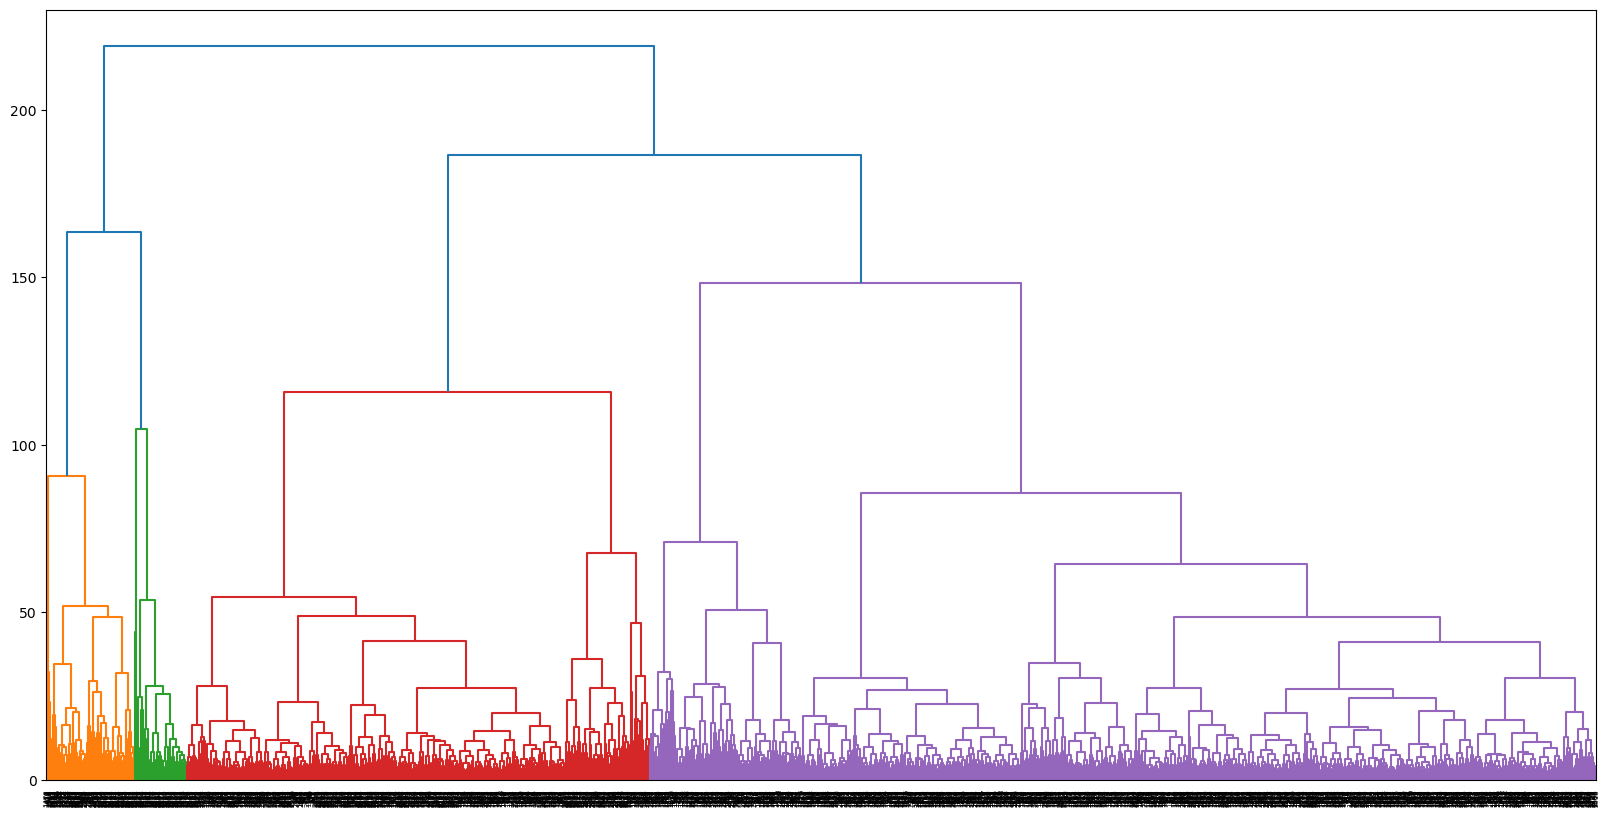

In [18]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [19]:
cutoff = 10

In [20]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
np.unique(clusters)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [27]:
cluster_map

morph
69333_-1          -1
69333_0_-1        -1
69333_1000_-1     -1
69333_1000_0     179
69333_1001_-1     -1
                ... 
69333_998_-1      -1
69333_999_-1      -1
69333_99_-1       -1
69333_9_-1        -1
69333_9_0        188
Length: 6054, dtype: int64

In [28]:

cluster_map = pd.Series(-1, index=morph_chars.index)
cluster_map.loc[morphotopes.index.values] = clusters

In [29]:
plotting = etcs.copy()

In [30]:
%%time
plotting['label'] = plotting.morph.map(cluster_map.to_dict())

CPU times: user 19 ms, sys: 1.16 ms, total: 20.1 ms
Wall time: 19.4 ms


In [31]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting.label)

NameError: name 'layer' is not defined

In [32]:
%%time
plotting['geometry'] = plotting.simplify(1)

CPU times: user 11.5 s, sys: 7 ms, total: 11.5 s
Wall time: 11.5 s


In [33]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
# layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 1.66 s, sys: 154 ms, total: 1.81 s
Wall time: 1.81 s


In [37]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [35]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting.label)

In [56]:
target_label = 9

In [36]:
# plotting[plotting.label == target_label].explore(prefer_canvas=True, tiles='cartodb positron')